In [1]:
%matplotlib inline

import datetime
import math
import numpy as np
import pandas as pd
from datetime import timedelta
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [4]:
def str_to_datetime(str):
    return datetime.datetime.strptime(str, "%Y-%m-%dT%H:%M:%S")

def datetime_to_str(d):
    return d.strftime('%Y-%m-%dT%H:%M:%S')

class CurveParams:
    def __init__(self, slope, shift, soft_start):
        self.slope = slope
        self.shift = shift
        self.soft_start = soft_start

class MappingParams:
    def __init__(self, curve_start, curve_end, time_start, time_end):
        self.curve_start = curve_start
        self.curve_end = curve_end
        self.time_start = time_start
        self.time_end = time_end

class Params:
    def __init__(self, curve, mapping):
        self.curve = curve
        self.mapping = mapping

# https://en.wikipedia.org/wiki/Generalised_logistic_function
def gen_logistic_curve(b, q, v, t):
    a = 0
#     b = 0.7
    k = 1.0
#     q = 0.5
#     v = 0.5
    m = 0
    c = 1
    print("t:" + str(t))
    return a + ((k - a) / (math.pow(c + q * (math.pow(math.e, (b * t) * -1)), (1 / v))))


def curve_for_instant(p, t):
    print("start:" + datetime_to_str(p.mapping.time_start))
    print("end:" + datetime_to_str(p.mapping.time_end))
    print("now:" + datetime_to_str(t))
    mapping_time_to_curve_range = interp1d([p.mapping.time_start.timestamp(), p.mapping.time_end.timestamp()], [p.mapping.curve_start, p.mapping.curve_end])
    return gen_logistic_curve(slope, shift, soft_start, mapping_time_to_curve_range(t.timestamp()))


def merge_curves(e, m):
    if e == 0 or e == 1:
        return m
    else:
        return e


def ev(iso, shutter_speed, aperture):
    ev100 = math.log2(math.pow(aperture, 2) / shutter_speed)
    if iso > 100:
        return ev100 + math.log2(iso / 100)
    else:
        return ev100

In [5]:
slope = 2.5
shift = 0.1
soft_start = 1.0

resolution = 690

first_noon_at_str = "2020-06-15T12:00:00"

astro_twi_start_at = str_to_datetime("2020-06-15T23:30:00")
astro_twi_end_at = str_to_datetime("2020-06-16T02:30:00")
first_noon_at = str_to_datetime(first_noon_at_str)
second_noon_at = str_to_datetime("2020-06-16T12:00:00")

curve_params = CurveParams(slope, shift, soft_start)

evening_mapping_params = MappingParams(6, -6, first_noon_at, astro_twi_end_at)
evening_params = Params(curve_params, evening_mapping_params)

morning_mapping_params = MappingParams(-6, 6, astro_twi_start_at, second_noon_at)
morning_params = Params(curve_params, morning_mapping_params)

df = pd.DataFrame({
    'date_time': pd.DatetimeIndex(pd.to_datetime(first_noon_at_str) + pd.to_timedelta(np.arange(resolution), 'm')),
    'aperture': pd.Series(np.full(resolution, 2.8), dtype='float64')
})

df['brigthness_curve_evening'] = pd.Series(df.apply(lambda r: curve_for_instant(evening_params, r['date_time']), axis=1), dtype='float64')
df['brigthness_curve_morning'] = pd.Series(df.apply(lambda r: curve_for_instant(morning_params, r['date_time']), axis=1), dtype='float64')
df['brigthness_curve'] = pd.Series(df.apply(lambda r: merge_curves(r['brigthness_curve_evening'], r['brigthness_curve_morning']), axis=1), dtype='float64')

display(df)

start:2020-06-15T12:00:00
end:2020-06-16T02:30:00
now:2020-06-15T12:00:00
t:5.172413793103448
start:2020-06-15T12:00:00
end:2020-06-16T02:30:00
now:2020-06-15T12:01:00
t:5.158620689655172
start:2020-06-15T12:00:00
end:2020-06-16T02:30:00
now:2020-06-15T12:02:00
t:5.144827586206897
start:2020-06-15T12:00:00
end:2020-06-16T02:30:00
now:2020-06-15T12:03:00
t:5.13103448275862
start:2020-06-15T12:00:00
end:2020-06-16T02:30:00
now:2020-06-15T12:04:00
t:5.117241379310345
start:2020-06-15T12:00:00
end:2020-06-16T02:30:00
now:2020-06-15T12:05:00
t:5.103448275862069
start:2020-06-15T12:00:00
end:2020-06-16T02:30:00
now:2020-06-15T12:06:00
t:5.089655172413793
start:2020-06-15T12:00:00
end:2020-06-16T02:30:00
now:2020-06-15T12:07:00
t:5.075862068965518
start:2020-06-15T12:00:00
end:2020-06-16T02:30:00
now:2020-06-15T12:08:00
t:5.062068965517241
start:2020-06-15T12:00:00
end:2020-06-16T02:30:00
now:2020-06-15T12:09:00
t:5.048275862068966
start:2020-06-15T12:00:00
end:2020-06-16T02:30:00
now:2020-06

ValueError: A value in x_new is below the interpolation range.

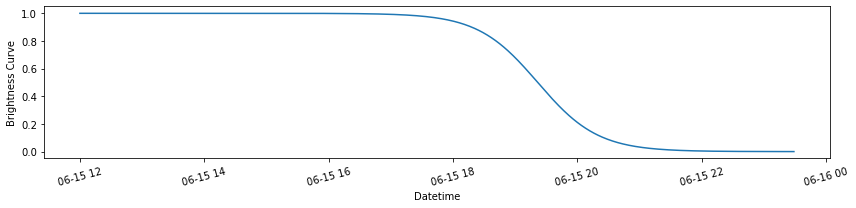

KeyError: 'brigthness_curve_morning'

In [17]:
def show_plot(x, y, y_label):
    plt.rcParams["figure.figsize"] = (12,3)
    plt.xticks(rotation=15)
    plt.xlabel("Datetime")
    plt.ylabel(y_label)
    plt.plot(x, y)
    plt.tight_layout()
    plt.show()

show_plot(df['date_time'], df['brigthness_curve_evening'], "Brightness Curve")
show_plot(df['date_time'], df['brigthness_curve_morning'], "Brightness Curve")
show_plot(df['date_time'], df['brigthness_curve'], "Brightness Curve")